# Keras에 내장된 사전 훈련 모델을 이용한 Image 분류

- ResNet50 pre-trained model 사용

- 1000 개의 class 분류 모델인 ResNet50 을 binary classifier (cat, dog) 으로 변형

- google colab 사용  

- My Drive 에 training data upload

## STEP #1: IMPORT LIBRARIES

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import load_img, img_to_array

## STEP #2: 사전 훈련된 가중치가 있는 모델 가져 오기

In [2]:
model = tf.keras.applications.ResNet50(weights = 'imagenet')

102981632/102967424 [==============================] - 2s 0us/step


## STEP #3: 사전 훈련된 모델 평가

지정한 URL 에서 data 를 가져와 압축해제

In [3]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs_filtered.zip', origin=_URL, 
                                      extract=True, cache_dir='/content/sample_data')

68616192/68606236 [==============================] - 1s 0us/step


**tf.keras.preprocessing.image.load_img** - image 를 PIL (Python Image Library) format 으로 load  

**tf.keras.preprocessing.image.img_to_array** - PIL image 를 numpy array 로 변경

In [31]:
sample_img= load_img(
    '/content/sample_data/datasets/cats_and_dogs_filtered/train/dogs/dog.1.jpg', target_size=(224, 224))

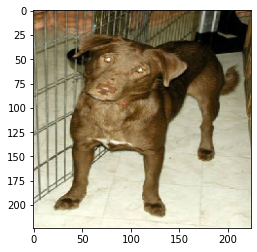

In [5]:
plt.imshow(sample_img)

In [6]:
sample_img = img_to_array(sample_img)
sample_img = np.expand_dims(sample_img, axis = 0)

sample_img.shape

(1, 224, 224, 3)

### ResNet50 의 입력 spec 에 맞도록 Sample_Image preprocessing

In [7]:
sample_img = tf.keras.applications.resnet50.preprocess_input(sample_img)

In [8]:
predictions = model.predict(sample_img)
print(predictions.shape)
print(predictions[0,:10])

(1, 1000)
[2.2736965e-06 7.6672637e-07 1.4949782e-08 1.0402839e-07 5.9049063e-07
 2.9649601e-07 1.5648220e-07 8.4392354e-07 4.5774959e-06 6.9982370e-08]


### 확률 분포로 반환된 prediction 을 category name 으로 decode

In [9]:
print('predictions:', tf.keras.applications.resnet50.decode_predictions(predictions, top = 5)[0])

49152/35363 [=========================================] - 0s 0us/step
predictions: [('n02099849', 'Chesapeake_Bay_retriever', 0.8515662), ('n02105412', 'kelpie', 0.091880426), ('n02099712', 'Labrador_retriever', 0.009123372), ('n02106550', 'Rottweiler', 0.006412113), ('n02099429', 'curly-coated_retriever', 0.0042715715)]


### ImageDataGenerator 생성

In [10]:
image_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
                    preprocessing_function= tf.keras.applications.resnet50.preprocess_input)

train_ds = image_datagen.flow_from_directory('/content/sample_data/datasets/cats_and_dogs_filtered/train', 
                                                   color_mode = 'rgb',
                                                   batch_size = 32,
                                                   target_size=(224, 224),
                                                   class_mode = 'categorical',
                                                   shuffle = True)

test_ds = image_datagen.flow_from_directory('/content/sample_data/datasets/cats_and_dogs_filtered/validation', 
                                                   color_mode = 'rgb',
                                                   batch_size = 32,
                                                   target_size=(224, 224),
                                                   class_mode = 'categorical')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


## STEP #4: 전이학습 적용 및 model RETRAIN 

- ResNet50 의 top layer 제거 (include_top = False)
- GlobalAaveragePooling2D + Dense() layer 5 개 추가
    - global_average_layer = keras.layers.GlobalAveragePooling2D()(base_model.output)
    - prediction_layer = keras.layers.Dense(units=2, activation='softmax')(global_average_layer)

In [11]:
base_model = tf.keras.applications.ResNet50(weights = 'imagenet', include_top = False)

94781440/94765736 [==============================] - 1s 0us/step


In [12]:
for layer in base_model.layers[-5:]:
    print(layer.name)

conv5_block3_2_relu
conv5_block3_3_conv
conv5_block3_3_bn
conv5_block3_add
conv5_block3_out


### base model 의 top 에 5 개 layer 추가

In [13]:
x = base_model.output

x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(1024, activation = 'relu')(x)
x = tf.keras.layers.Dense(512, activation = 'relu')(x)
x = tf.keras.layers.Dense(256, activation = 'relu')(x)
x = tf.keras.layers.Dense(64, activation = 'relu')(x)
preds = tf.keras.layers.Dense(2, activation = 'softmax')(x)

In [14]:
model = tf.keras.models.Model(inputs = base_model.input, outputs = preds)

In [15]:
for layer in model.layers[-10:]:
    print(layer.name)

conv5_block3_3_conv
conv5_block3_3_bn
conv5_block3_add
conv5_block3_out
global_average_pooling2d
dense
dense_1
dense_2
dense_3
dense_4


### Fine tuning 하기 전에 새로이 add 한 Top 5 layer 들을 1 차 training 하여 초기화

In [16]:
for layer in model.layers[:-5]:
    layer.trainable = False

for layer in model.layers[-5:]:
    layer.trainable = True

In [17]:
model.compile(optimizer = 'Adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [18]:
model.fit(train_ds,  epochs = 5)

Epoch 1/5
63/63 [==============================] - 14s 141ms/step - loss: 0.1429 - accuracy: 0.9545
Epoch 2/5
63/63 [==============================] - 9s 140ms/step - loss: 0.0292 - accuracy: 0.9915
Epoch 3/5
63/63 [==============================] - 9s 147ms/step - loss: 0.0539 - accuracy: 0.9865
Epoch 4/5
63/63 [==============================] - 9s 140ms/step - loss: 0.0472 - accuracy: 0.9840
Epoch 5/5
63/63 [==============================] - 9s 142ms/step - loss: 0.0250 - accuracy: 0.9920


In [19]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, None, None,   0           ['input_2[0][0]']                
                                3)                                                                
                                                                                                  
 conv1_conv (Conv2D)            (None, None, None,   9472        ['conv1_pad[0][0]']              
                                64)                                                           

### Top 50 개 layer 를 fine tuning

In [20]:
for layer in model.layers[:-50]:
    layer.trainable = False

for layer in model.layers[-50:]:
    layer.trainable = True

In [21]:
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [22]:
history = model.fit(train_ds, epochs = 10, validation_data=test_ds, verbose=1)

Epoch 1/10
63/63 [==============================] - 22s 245ms/step - loss: 0.1500 - accuracy: 0.9600 - val_loss: 29.6349 - val_accuracy: 0.9260
Epoch 2/10
63/63 [==============================] - 14s 217ms/step - loss: 0.0425 - accuracy: 0.9915 - val_loss: 0.7163 - val_accuracy: 0.9770
Epoch 3/10
63/63 [==============================] - 14s 216ms/step - loss: 0.0562 - accuracy: 0.9835 - val_loss: 2.2401 - val_accuracy: 0.9230
Epoch 4/10
63/63 [==============================] - 14s 217ms/step - loss: 0.0188 - accuracy: 0.9940 - val_loss: 0.5295 - val_accuracy: 0.9540
Epoch 5/10
63/63 [==============================] - 14s 216ms/step - loss: 0.0394 - accuracy: 0.9940 - val_loss: 30.1503 - val_accuracy: 0.6460
Epoch 6/10
63/63 [==============================] - 14s 228ms/step - loss: 0.0388 - accuracy: 0.9920 - val_loss: 9.4341 - val_accuracy: 0.9070
Epoch 7/10
63/63 [==============================] - 14s 217ms/step - loss: 0.0281 - accuracy: 0.9925 - val_loss: 0.3860 - val_accuracy: 0.95

In [23]:
model.evaluate(test_ds, verbose=0)

[0.4205688238143921, 0.9580000042915344]

## STEP #5: MODEL 평가

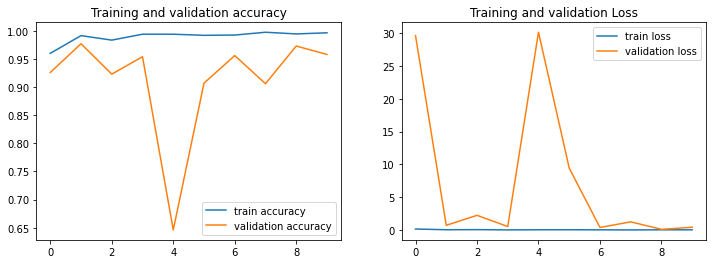

In [24]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.plot(history.history['accuracy'], label='train accuracy')
ax1.plot(history.history['val_accuracy'], label='validation accuracy')
ax1.set_title('Training and validation accuracy')
ax1.legend()

ax2.plot(history.history['loss'], label='train loss')
ax2.plot(history.history['val_loss'], label='validation loss')
ax2.set_title('Training and validation Loss')
ax2.legend()

In [25]:
test_imgs, test_labels = next(test_ds)
y_true = np.argmax(test_labels, axis=1)

In [26]:
y_pred = model.predict(test_imgs)
predictions = np.argmax(y_pred, axis=1)

print(y_true)
print(predictions)

[0 1 0 0 1 1 0 1 1 0 0 0 0 0 0 1 1 1 0 1 1 0 1 1 0 1 0 0 1 1 0 1]
[0 1 0 0 1 1 0 1 1 0 0 0 0 0 0 0 0 1 0 1 1 0 1 1 0 0 0 0 1 1 0 1]


In [27]:
from PIL import Image
from urllib import request
from io import BytesIO

url = "https://i.pinimg.com/736x/b5/c6/38/b5c638e81c104937e4b79379a9544c70.jpg"
res = request.urlopen(url).read()
img = Image.open(BytesIO(res)).resize((224,224))

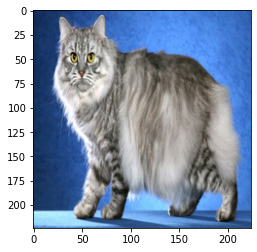

In [28]:
plt.imshow(img)

In [29]:
sample_img = tf.keras.preprocessing.image.img_to_array(img)
sample_img = np.expand_dims(sample_img, axis = 0)
sample_img.shape

(1, 224, 224, 3)

In [30]:
sample_img = tf.keras.applications.resnet50.preprocess_input(sample_img)

prediction = model.predict(sample_img)
print('Predictions:', ['cat', 'dog'][np.argmax(prediction)])

Predictions: cat
